In [1]:
import pickle

import matplotlib.pyplot as plt
import cv2

%matplotlib inline

In [2]:
import numpy as np
import theano
import theano.tensor as T
import lasagne

Using gpu device 0: GeForce GTX 750 (CNMeM is enabled with initial size: 70.0% of memory, cuDNN 5005)


In [3]:
import sys
import os
import time

In [4]:
from OpenData import *

In [5]:
pkl_dict = unpickle('cifar-10-batches-py/data_batch_1')
labels=pkl_dict['labels']
images=pkl_dict['data']
labels = np.array(labels,dtype=np.uint8)
images = images / np.float32(256)
X_train = images.reshape((10000,3,32,32))
y_train = labels
for i in ('2','3','4','5'):
    pkl_dict = unpickle('cifar-10-batches-py/data_batch_'+i)
    labels=pkl_dict['labels']
    images=pkl_dict['data']
    labels = np.array(labels,dtype=np.uint8)
    images = images / np.float32(256)
    X_train = np.vstack((X_train,images.reshape((10000,3,32,32))))
    y_train = np.concatenate((y_train,labels))

In [6]:
pkl_dict = unpickle('cifar-10-batches-py/test_batch')
labels=pkl_dict['labels']
images=pkl_dict['data']
labels = np.array(labels,dtype=np.uint8)
images = images / np.float32(256)
X_test = images.reshape((10000,3,32,32))
y_test = labels

In [7]:
def build_cnn(input_var=None):
    network = lasagne.layers.InputLayer(shape=(None, 3, 32, 32),
                                        input_var=input_var)
    
    network = lasagne.layers.Conv2DLayer(
            network, num_filters=64, filter_size=(3, 3),
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform())
    
    network = lasagne.layers.Conv2DLayer(
            network, num_filters=128, filter_size=(3, 3),
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform())
    
    network = lasagne.layers.Conv2DLayer(
            network, num_filters=256, filter_size=(3, 3),
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform())


    network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))

    network = lasagne.layers.DenseLayer(
            lasagne.layers.dropout(network, p=.5),
            num_units=256,
            nonlinearity=lasagne.nonlinearities.rectify)

    network = lasagne.layers.DenseLayer(
            lasagne.layers.dropout(network, p=.5),
            num_units=256,
            nonlinearity=lasagne.nonlinearities.rectify)

    network = lasagne.layers.DenseLayer(
            lasagne.layers.dropout(network, p=.5),
            num_units=10,
            nonlinearity=lasagne.nonlinearities.softmax)

    return network

In [8]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

## Создаём нейросеть

In [9]:
input_var = T.tensor4('inputs')
target_var = T.ivector('targets')

In [10]:
network = build_cnn(input_var)

In [11]:
prediction = lasagne.layers.get_output(network)
loss = lasagne.objectives.categorical_crossentropy(prediction, target_var)
loss = loss.mean()

In [12]:
params = lasagne.layers.get_all_params(network, trainable=True)
updates = lasagne.updates.nesterov_momentum(
            loss, params, learning_rate=0.01, momentum=0.9)

test_prediction = lasagne.layers.get_output(network, deterministic=True)
test_loss = lasagne.objectives.categorical_crossentropy(test_prediction,
                                                            target_var)
test_loss = test_loss.mean()

test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_var),
                        dtype=theano.config.floatX)

In [13]:
pred = test_prediction.argmax(-1)
f_predict = theano.function([input_var], pred)

In [14]:
train_fn = theano.function([input_var, target_var], 
                           loss, 
                           updates=updates,
                           allow_input_downcast=True)

val_fn = theano.function([input_var, target_var], 
                         [test_loss, test_acc],
                         allow_input_downcast=True)

## Обучаем модель

In [15]:
num_epochs = 10

In [16]:
BATCH_SIZE = 128

In [17]:
for epoch in range(num_epochs):
    train_err = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train, BATCH_SIZE, shuffle=True):
        inputs, targets = batch
        train_err += train_fn(inputs, targets)
        train_batches += 1

    val_err = 0
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_test, y_test, BATCH_SIZE, shuffle=False):
        inputs, targets = batch
        err, acc = val_fn(inputs, targets)
        val_err += err
        val_acc += acc
        val_batches += 1
        
    print("Epoch: {}, train:{}, val:{}".format(epoch, 
                                               train_err/train_batches,
                                               val_err/val_batches))

Epoch: 0, train:1.9789669853, val:1.64525071627
Epoch: 1, train:1.58474142643, val:1.33365293955
Epoch: 2, train:1.38088755516, val:1.17454695854
Epoch: 3, train:1.22222228769, val:1.04839461048
Epoch: 4, train:1.10333632414, val:0.964221224571
Epoch: 5, train:1.00194342366, val:0.924189441479
Epoch: 6, train:0.929169656833, val:0.873562286297
Epoch: 7, train:0.85783827259, val:0.840669734356
Epoch: 8, train:0.79731524174, val:0.823294548652
Epoch: 9, train:0.734492662702, val:0.806882645839


# Обрабатываем оставшиеся изображении

In [18]:
y_true = []
y_pred = []
test_size=10000
for i in range(test_size):
    y_true.append(int(y_test[i]))
    y_pred.append(f_predict([X_test[i]])[0])

In [19]:
from sklearn.metrics import confusion_matrix

In [20]:
CM = confusion_matrix(y_true, y_pred)

/usr/local/lib/python2.7/dist-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


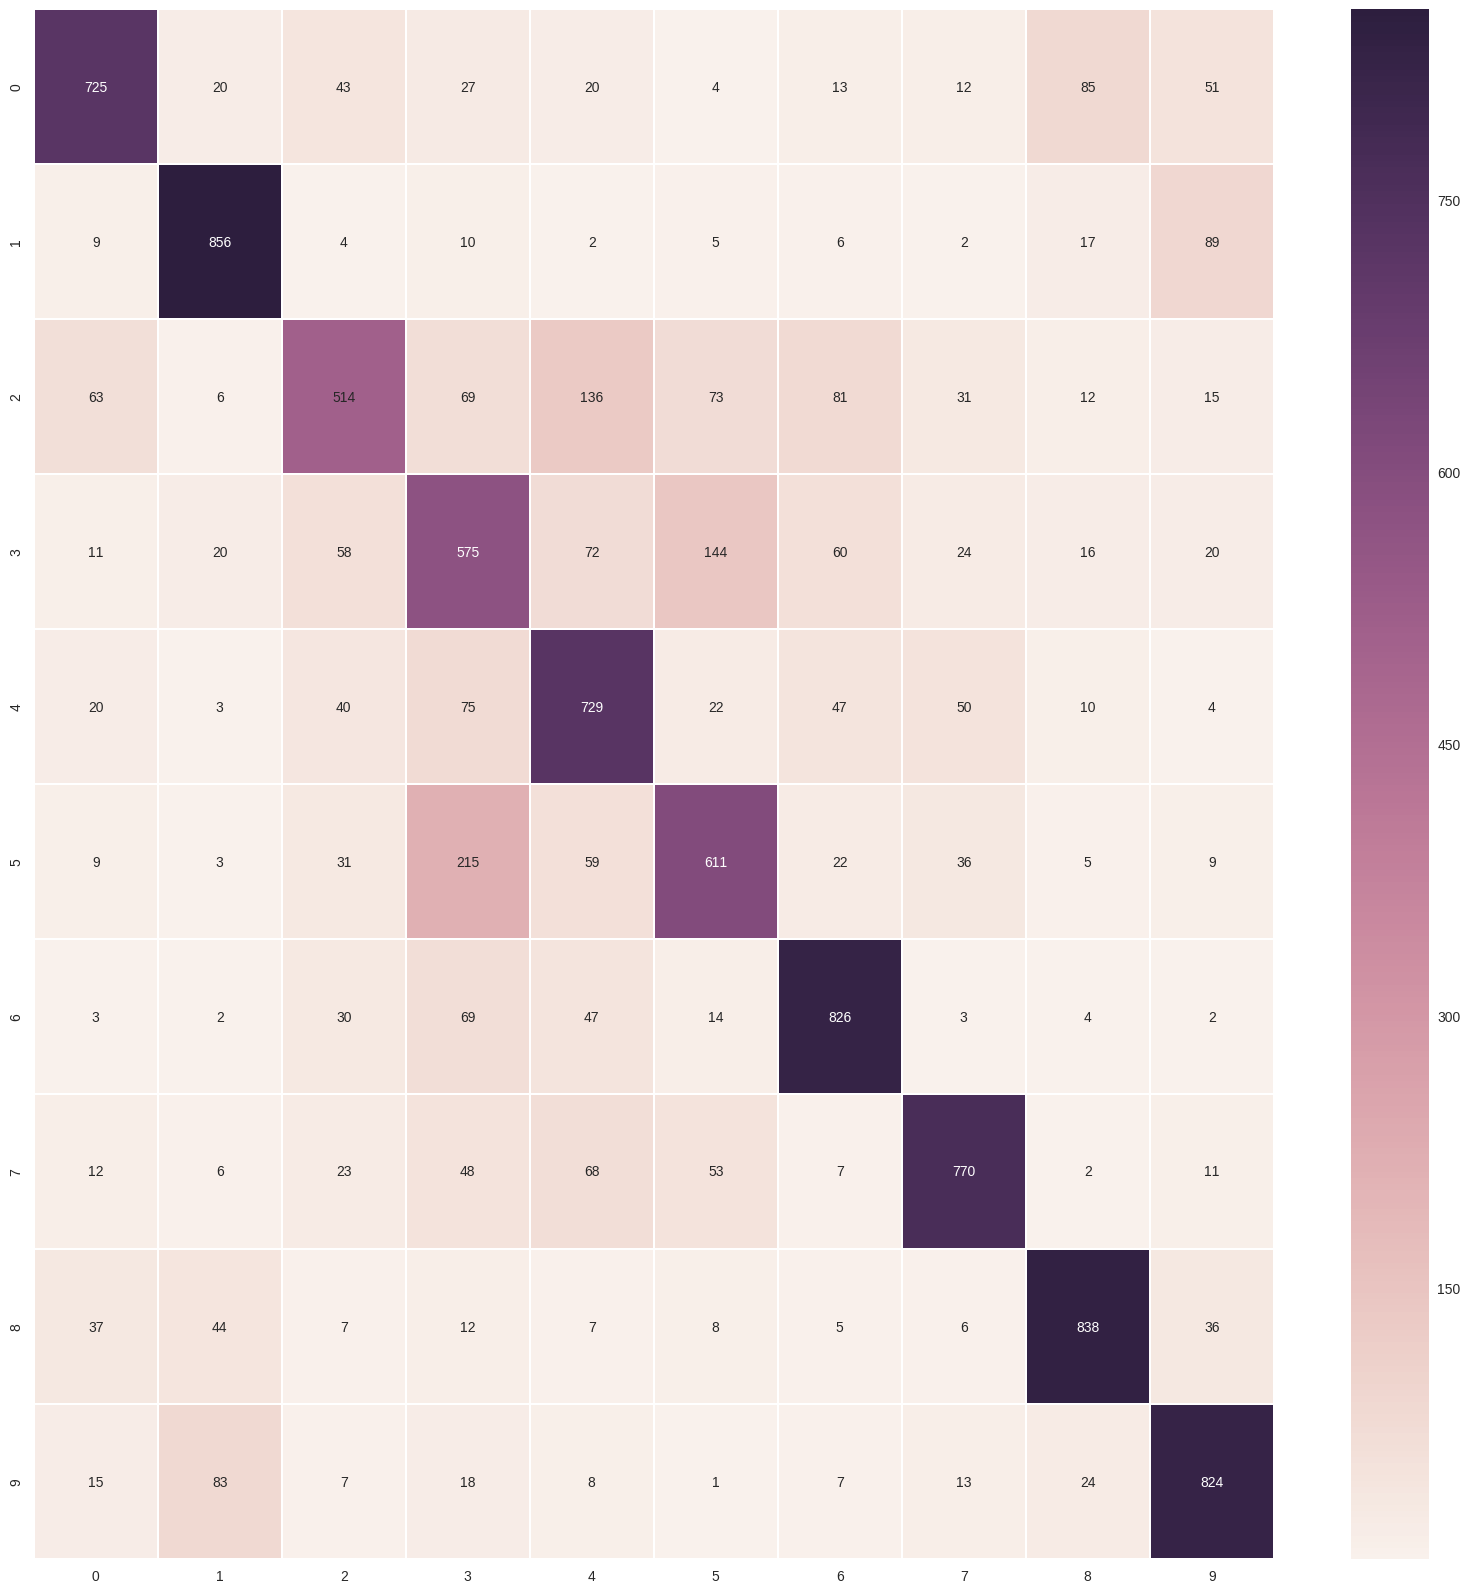

In [21]:
import seaborn as sns

fig = plt.figure(figsize=(20, 20))
sns.heatmap(CM, annot=True, fmt="d", linewidths=.5)
plt.show()

In [22]:
from sklearn.metrics import classification_report
target_names = ['class'+str(i) for i in range(0,10)]
print(classification_report(y_true, y_pred, target_names=target_names))


             precision    recall  f1-score   support

     class0       0.80      0.72      0.76      1000
     class1       0.82      0.86      0.84      1000
     class2       0.68      0.51      0.59      1000
     class3       0.51      0.57      0.54      1000
     class4       0.64      0.73      0.68      1000
     class5       0.65      0.61      0.63      1000
     class6       0.77      0.83      0.80      1000
     class7       0.81      0.77      0.79      1000
     class8       0.83      0.84      0.83      1000
     class9       0.78      0.82      0.80      1000

avg / total       0.73      0.73      0.73     10000

